<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/skin_cancer_bt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer BT

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/archive (1).zip"


Archive:  /content/drive/My Drive/archive (1).zip
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024763.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024771.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024800.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024913.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024948.jpg  
  inflating: s

## Install MONAI, updata fastai, any other installs go here

In [3]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

     |████████████████████████████████| 1.2 MB 31.0 MB/s 
     |████████████████████████████████| 17.2 MB 25 kB/s 
     |████████████████████████████████| 83.6 MB 155 kB/s 
     |████████████████████████████████| 26.2 MB 133.3 MB/s 
     |████████████████████████████████| 27.3 MB 1.1 MB/s 
     |████████████████████████████████| 60.0 MB 1.4 MB/s 
     |████████████████████████████████| 75.9 MB 123 kB/s 


In [10]:
#pip install fastai==2#.7.1

In [4]:
#Other installs here
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-1fv7e7_g/base-rbt_64a92845bab1447696b8763e5e395003
  Running command git clone -q https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-1fv7e7_g/base-rbt_64a92845bab1447696b8763e5e395003
     |████████████████████████████████| 569 kB 28.5 MB/s 
     |████████████████████████████████| 41 kB 584 kB/s 
     |████████████████████████████████| 549 kB 85.9 MB/s 
     |████████████████████████████████| 182 kB 96.0 MB/s 
  Created wheel for base-rbt: filename=base_rbt-0.0.1-py3-none-any.whl size=16049 sha256=36f7c47e009a8fe71327d0c274c3598f11d1796c266714b11668a6c3b3028b47
  Stored in directory: /tmp/pip-ephem-wheel-cache-u6_sncvp/wheels/b3/25/be/8368facea57a956938db327bdd708e7f93ca5738de036e2c6e
Successfully built base-rbt


## Imports

In [5]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
#print_config()

In [6]:
import fastai
from fastai.vision.all import *
#Other imports here

from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

fastai.__version__

'2.7.10'

In [14]:
!ls

drive  sample_data  skin_cancer_ISIC


## Read image filenames from the dataset folders

In [7]:
#kaggle
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [8]:
#colab
train_dir='skin_cancer_ISIC/Train'
test_dir='skin_cancer_ISIC/Test'

In [9]:
#train
class_names0 = os.listdir(train_dir)
class_names = sorted(class_names0)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

## Now get the training data and validation data etc

In [10]:
#Helper functions to extract class names from the filenames
import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None

def label_func(x): return extract_text(x.as_posix())

#files names
fnames = get_image_files(train_dir)

#Extract training set
max_num =100 #maximum number of samples in each class
count_dict = {i:0 for i in class_names}
fnames_train = []
for i in fnames:
    #st=extract_text(i.as_posix())
    st=label_func(i)
    
    if count_dict[st]<max_num: #no more than 100 samples per category
        fnames_train.append(i)
        count_dict[st]+=1
                
#We further partition fnames_train into a tune-valiation set
count_dict2 = {i:0 for i in class_names}
fnames_tune = []
for i in fnames_train:
    st = label_func(i)
    if count_dict2[st] < 0.8*count_dict[st]:
        fnames_tune.append(i)
        count_dict2[st]+=1
        
def get_difference(x1, x2):
    return list(set(x1) - set(x2))

fnames_valid = get_difference(fnames_train,fnames_tune)

fnames_test = get_difference(fnames,fnames_train) + get_image_files(test_dir)

#sanity check
def display_dict(_fnames):
    
    _labels = [label_func(i) for i in _fnames]
    tem_dict = {i:_labels.count(i) for i in _labels}
    return tem_dict

tem_dict = display_dict(fnames)
print(f'The "original" training set: \n {tem_dict}\n')

tem_dict = display_dict(fnames_train)
print(f'Training set: used to train BT etc i.e. viewed as unlabelled \n {tem_dict}\n')

print('The training set is partitioned into tune-valid sets, with ~ 80-20 split\n')

tem_dict = display_dict(fnames_tune)
print(f'Tune set: used to train classifiers on representations \n {tem_dict}\n')

tem_dict = display_dict(fnames_valid)
print(f'Valid set: used to validate the classifiers trained above \n {tem_dict}\n')

tem_dict = display_dict(fnames_test)
print(f'Test set: only examine at the very end {tem_dict}\n')


The "original" training set: 
 {'dermatofibroma': 95, 'seborrheic keratosis': 77, 'melanoma': 438, 'squamous cell carcinoma': 181, 'vascular lesion': 139, 'pigmented benign keratosis': 462, 'nevus': 357, 'basal cell carcinoma': 376, 'actinic keratosis': 114}

Training set: used to train BT etc i.e. viewed as unlabelled 
 {'dermatofibroma': 95, 'seborrheic keratosis': 77, 'melanoma': 100, 'squamous cell carcinoma': 100, 'vascular lesion': 100, 'pigmented benign keratosis': 100, 'nevus': 100, 'basal cell carcinoma': 100, 'actinic keratosis': 100}

The training set is partitioned into tune-valid sets, with ~ 80-20 split

Tune set: used to train classifiers on representations 
 {'dermatofibroma': 76, 'seborrheic keratosis': 62, 'melanoma': 80, 'squamous cell carcinoma': 80, 'vascular lesion': 80, 'pigmented benign keratosis': 80, 'nevus': 80, 'basal cell carcinoma': 80, 'actinic keratosis': 80}

Valid set: used to validate the classifiers trained above 
 {'dermatofibroma': 19, 'basal cell 

## Now get the training dataloader and view the data

In [11]:
#get data

#TODO: We can probably avoid these dataloaders?

device ='cuda' if torch.cuda.is_available() else 'cpu'

bs=256
size=128
n_in=3
numfit=200
ps=1024

item_tfms = [Resize(size)]

dls_train  = ImageDataLoaders.from_path_func(train_dir, fnames_train, label_func,
                                      bs=bs,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device
                                    )
x,y = dls_train.one_batch()

dls_tune = ImageDataLoaders.from_path_func(train_dir, fnames_tune, label_func,
                                      bs=len(fnames_valid),
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device
                                    )
xtune,ytune = dls_tune.one_batch()

dls_valid  = ImageDataLoaders.from_path_func(train_dir, fnames_valid, label_func,
                                      bs=len(fnames_valid),
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device
                                    )
xval,yval = dls_valid.one_batch()

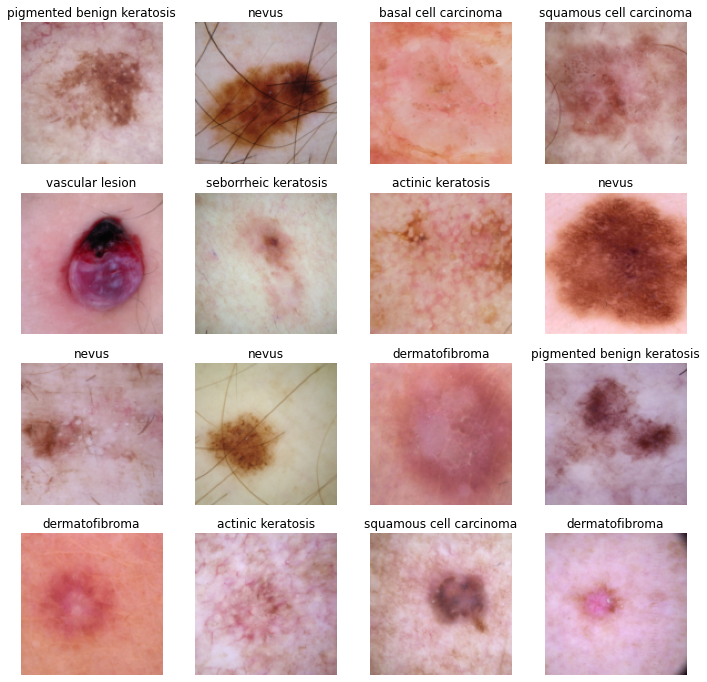

In [16]:
dls_train.show_batch(max_n=16)

## BT stuff now!

In [12]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

In [13]:
#Compute the mean and standard deviation of the dataset: 
def compute_mean_std(dls):
    # Initialize variables to store the sum and sum of squares of the data
    channel_sum = [0, 0, 0]
    channel_sum_squares = [0, 0, 0]

    # Iterate over the data in the dataloader
    for data,y in dls:
        
        batch_size, _, height, width = data.shape

        # Compute the sum and sum of squares of the data for each channel
        for channel in range(3):
            channel_sum[channel] += data[:, channel, :, :].sum()
            channel_sum_squares[channel] += (data[:, channel, :, :] ** 2).sum()

    # Calculate the number of elements in the data
    num_elements = batch_size * height * width * len(dls)

    # Calculate the mean and standard deviation for each channel
    means = [(channel_sum[i] / num_elements).item() for i in range(3)]
    stddevs = [(((channel_sum_squares[i] / num_elements) - means[i]**2)**0.5).item() for i in range(3)]

    return means, stddevs

means, stddevs = compute_mean_std(dls_train.train)

isic_stats_128 = means,stddevs #when shape is 128
print("Means:", means)
print("Standard deviations:", stddevs)

#Normalize.from_stats(mean=means,std=stddevs)

Means: [0.7608470916748047, 0.5887757539749146, 0.5945264101028442]
Standard deviations: [0.1222013458609581, 0.14214268326759338, 0.15640003979206085]


In [ ]:
isic_stats_128

([0.7609121799468994, 0.5869480967521667, 0.5924641489982605],
 [0.12186530977487564, 0.14097826182842255, 0.15697918832302094])

Ok, there is now a question of which augmentations to use...

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


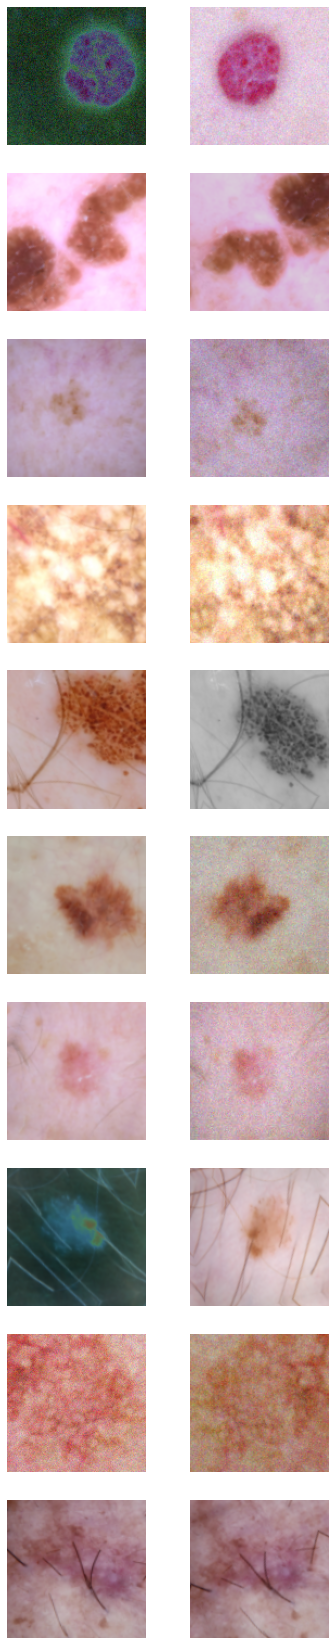

In [14]:
#Ok, there is now a huge question of which augmentations to apply!!!


#Moral: Maybe too much noise?
aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,blur_r=(0.1,3),
                    rotate=True,jitter=True,noise=True,bw=True,blur=False,solar=True, #Whether to use aug or not
                    resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=45,blur_s=11,sol_t=0.0125,sol_a=0.0125, #hps of augs
                    flip_p=0.1, rotate_p=0.75,noise_p=0.5, jitter_p=0.25, bw_p=0.1, blur_p=0.5,sol_p=0.05, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))



#This was superior
# aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,blur_r=(0.5,2),
#                     rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
#                     resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=20,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
#                     flip_p=0.1, rotate_p=0.75,noise_p=0.25, jitter_p=0.25, bw_p=0.05, blur_p=0.25,sol_p=0.05, #prob of performing aug
#                     same_on_batch=False,stats=isic_stats_128, cuda=(device=='cuda'))



aug_pipelines = [aug_pipelines_1,aug_pipelines_1]

#View the augmentations the "usual way"
show_bt_batch(dls=dls_train,n_in=3,aug=aug_pipelines,n=10,print_augs=True)

## Train BT

In [15]:
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
learn.fit(300)
print('Everything but blur')

epoch,train_loss,valid_loss,time
0,302.286865,None,00:12
1,241.815231,None,00:06
2,216.085724,None,00:07
3,198.816986,None,00:06
4,191.245773,None,00:06
5,181.803055,None,00:06
6,173.598801,None,00:06
7,166.013748,None,00:06
8,159.746399,None,00:06
9,155.063034,None,00:06


Your generator is empty.


Everything but blur


In [ ]:
#clone model 
import pickle
copyed_model = pickle.loads(pickle.dumps(model))

In [ ]:
#17.4250

## Linear evaluation / fine tuning:


Pipeline: RandomResizedCrop
Pipeline: 


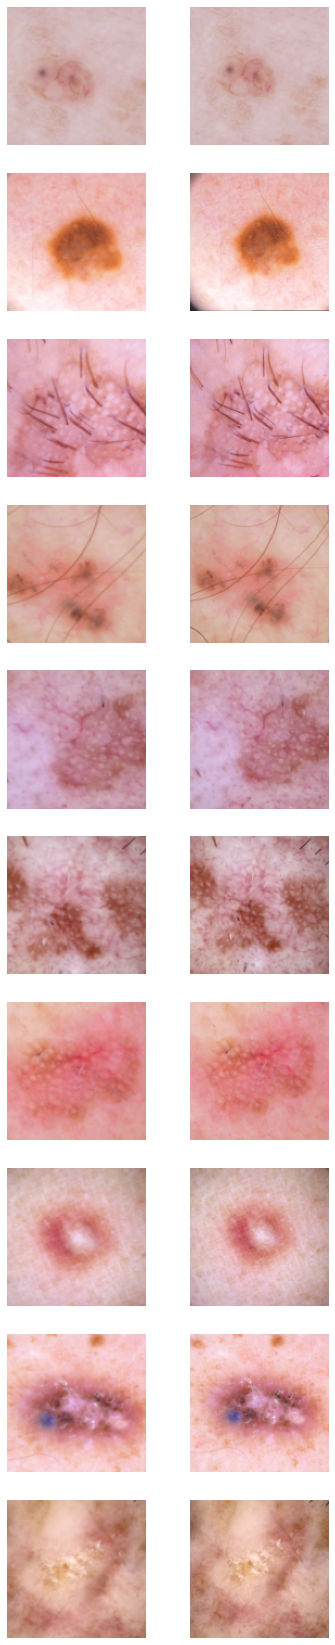

In [16]:
#Something weird goes on with normalization...

numfit=200
n_in=3

criterion = nn.CrossEntropyLoss()

isic_stats_128 = ([0.7609121799468994, 0.5869480967521667, 0.5924641489982605],[0.12186530977487564, 0.14097826182842255, 0.15697918832302094])
#stats = cifar_stats

aug_pipelines_tune=[get_linear_batch_augs(size=size,stats=None,resize=True,resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3))]

show_linear_batch(dls=dls_tune,n_in=n_in,n=10,aug=aug_pipelines_tune,print_augs=True)

In [19]:
#fine tune standard xresnet (pre-trained!) on the raw pixels
def fit_model(x,y,model,weight_decay=0):
    
    #opt = Adam(model.parameters(),lr=0.001)
    
    opt = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=weight_decay)
    

    #opt_func = partial(optim.Adam, lr=0.001, weight_decay=0.0005)

 
    for epoch in range(numfit):

        x = aug_pipelines_tune[0](x) #augmentation
        out = model(x)
        loss = criterion(out,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        #print(loss)
        
    return model

@torch.no_grad()
def predict_model(xval,yval,model):
    
    #need accuracy, also so F1 score and whatever other stuff we need...
    model.eval()
    
    test_eq(model.encoder.training,False)
    
    N=xval.shape[0]
    ypred=model(xval)
    correct = (torch.argmax(ypred,dim=1) == yval).type(torch.FloatTensor)
    num_correct = correct.sum()
    accuracy = num_correct/N
    return accuracy.item()
    
if __name__ == '__main__':
    
    encoder = pickle.loads(pickle.dumps(fastai_encoder)) #copy
    
    #Just do linear evaluation...
    encoder = grad_on(encoder,on=False)
    encoder.eval()
    acc_dict={}
    wd = [0.0,0.01,0.1,0.2,0.3]
    
    for weight_decay in wd:
    
        acc_dict={}
        for i in range(10):

            #assert False

            #encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
            model = LinearModel(encoder=encoder,indim=1024,outdim=9).cuda() #composition of encoder and linear head
            model = fit_model(xtune,ytune,model,weight_decay=weight_decay)

            acc = predict_model(xval,yval,model)

            acc_dict[i] = acc

            print(f'Accuracy is {acc}') #Accuracy is 0.32758620381355286

        acc_dict['mean'] = (sum(list(acc_dict.values()))/len(acc_dict.values()))
        acc_dict['weight_decay'] = weight_decay

        print(acc_dict)

Accuracy is 0.25287356972694397
Accuracy is 0.26436781883239746
Accuracy is 0.29885056614875793
Accuracy is 0.21264368295669556
Accuracy is 0.29885056614875793
Accuracy is 0.23563218116760254
Accuracy is 0.28735631704330444
Accuracy is 0.2068965584039688
Accuracy is 0.270114928483963
Accuracy is 0.24712643027305603
{0: 0.25287356972694397, 1: 0.26436781883239746, 2: 0.29885056614875793, 3: 0.21264368295669556, 4: 0.29885056614875793, 5: 0.23563218116760254, 6: 0.28735631704330444, 7: 0.2068965584039688, 8: 0.270114928483963, 9: 0.24712643027305603, 'mean': 0.25747126191854475, 'weight_decay': 0.0}
Accuracy is 0.2068965584039688
Accuracy is 0.19540229439735413
Accuracy is 0.2298850566148758
Accuracy is 0.26436781883239746
Accuracy is 0.3045977056026459
Accuracy is 0.3218390941619873
Accuracy is 0.23563218116760254
Accuracy is 0.2068965584039688
Accuracy is 0.27586206793785095
Accuracy is 0.23563218116760254
{0: 0.2068965584039688, 1: 0.19540229439735413, 2: 0.2298850566148758, 3: 0.2643

## Baseline results for set of augmentations above: Everything but blur

In [ ]:
#mean = 0.2574, with weight_decay=0. But similar results for other weight decay values
#{0: 0.25287356972694397, 1: 0.26436781883239746, 2: 0.29885056614875793, 3: 0.21264368295669556, 4: 0.29885056614875793, 5: 0.23563218116760254, 6: 0.28735631704330444, 7: 0.2068965584039688, 8: 0.270114928483963, 9: 0.24712643027305603, 'mean': 0.25747126191854475, 'weight_decay': 0.0}
